# ATP Tennis Match Outcome Prediction

### Problem Statement

You have been tasked with a new project for our partnership with the sports analytics company "GameInsight." The challenge is to predict the outcomes of tennis matches accurately. Leveraging historical match data, we aim to build a machine learning model that can forecast whether Player 1 or Player 2 will win a given match. This predictive capability will enhance GameInsight's analytics offerings and support strategic decision-making for teams and broadcasters.

### Objective

Develop a robust machine learning model to predict the outcomes of tennis matches using historical match data. The model should achieve a significantly higher accuracy than the baseline and provide valuable insights into factors influencing match results. Key tasks include data preprocessing, feature engineering, model development, hyperparameter tuning, and comprehensive evaluation to ensure the model's reliability and performance.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

np.random.seed(11)

In [60]:
ds = pd.read_csv('/kaggle/input/atp-tennis-data/tennis_data.csv', parse_dates=['Date'])

/tmp/ipykernel_33/478033654.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  ds = pd.read_csv('/kaggle/input/atp-tennis-data/tennis_data.csv', parse_dates=['Date'])


## Data Exploration

In [61]:
ds.shape, ds.size

((36120, 54), 1950480)

In [62]:
ds.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'PSW', 'PSL', 'MaxW', 'MaxL',
       'AvgW', 'AvgL', 'EXW', 'EXL', 'LBW', 'LBL', 'SJW', 'SJL', 'UBW', 'UBL',
       'pl1_flag', 'pl1_year_pro', 'pl1_weight', 'pl1_height', 'pl1_hand',
       'pl2_flag', 'pl2_year_pro', 'pl2_weight', 'pl2_height', 'pl2_hand'],
      dtype='object')

In [63]:
ds.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,pl1_flag,pl1_year_pro,pl1_weight,pl1_height,pl1_hand,pl2_flag,pl2_year_pro,pl2_weight,pl2_height,pl2_hand
0,1,Adelaide,Adelaide International 1,2022-01-03,ATP250,Outdoor,Hard,1st Round,3,Kwon S.W.,...,KOR,2015.0,72.0,180.0,Right-Handed,JPN,2014.0,64.0,170.0,Left-Handed
1,1,Adelaide,Adelaide International 1,2022-01-03,ATP250,Outdoor,Hard,1st Round,3,Monteiro T.,...,BRA,2011.0,78.0,183.0,Left-Handed,GER,2014.0,80.0,188.0,Right-Handed
2,1,Adelaide,Adelaide International 1,2022-01-03,ATP250,Outdoor,Hard,1st Round,3,Djere L.,...,SRB,2013.0,80.0,185.0,Right-Handed,ESP,2011.0,76.0,180.0,Right-Handed
3,1,Adelaide,Adelaide International 1,2022-01-03,ATP250,Outdoor,Hard,1st Round,3,Johnson S.,...,USA,2012.0,86.0,188.0,Right-Handed,AUS,2018.0,85.0,188.0,Right-Handed
4,1,Adelaide,Adelaide International 1,2022-01-04,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,...,FRA,2016.0,71.0,175.0,Left-Handed,DEN,2020.0,77.0,188.0,Right-Handed


In [64]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36120 entries, 0 to 36119
Data columns (total 54 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ATP           36120 non-null  int64         
 1   Location      36120 non-null  object        
 2   Tournament    36120 non-null  object        
 3   Date          36120 non-null  datetime64[ns]
 4   Series        36120 non-null  object        
 5   Court         36120 non-null  object        
 6   Surface       36120 non-null  object        
 7   Round         36120 non-null  object        
 8   Best of       36120 non-null  int64         
 9   Winner        36120 non-null  object        
 10  Loser         36120 non-null  object        
 11  WRank         36107 non-null  float64       
 12  LRank         36040 non-null  float64       
 13  WPts          36109 non-null  float64       
 14  LPts          36041 non-null  float64       
 15  W1            35888 non-null  float6

In [65]:
betting_odds_columns = [
    'B365W', 'B365L',  # Bet365 odds
    'PSW', 'PSL',      # Pinnacle Sports odds
    'MaxW', 'MaxL',    # Maximum odds offered by any bookmaker
    'AvgW', 'AvgL',    # Average odds offered by bookmakers
    'EXW', 'EXL',      # Betfair Exchange odds
    'LBW', 'LBL',      # Ladbrokes odds
    'SJW', 'SJL',      # Stan James odds
    'UBW', 'UBL'       # Unibet odds
]

In [66]:
ds.describe(include='number')

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W2,L2,...,SJW,SJL,UBW,UBL,pl1_year_pro,pl1_weight,pl1_height,pl2_year_pro,pl2_weight,pl2_height
count,36120.000000,36120.000000,36107.000000,36040.000000,36109.000000,36041.000000,35888.000000,35891.000000,35549.000000,35549.000000,...,15572.000000,15579.000000,5309.000000,5309.000000,36024.000000,36024.000000,36024.000000,35471.000000,35471.000000,35471.000000
mean,31.738594,3.393134,57.546875,88.603219,1976.843668,1143.267362,5.803946,4.095623,5.785226,3.935723,...,1.796538,3.557943,1.819319,3.567555,2004.997113,80.853903,186.981290,2005.076880,79.958191,186.339658
std,18.064395,0.794815,71.003583,111.068647,2409.161696,1301.933270,1.229424,1.833968,1.246794,1.862858,...,1.004273,3.272510,1.038893,3.412837,5.182776,7.882514,12.038932,11.846051,7.517481,19.787786
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.010000,1.010000,1.020000,1989.000000,7.000000,10.000000,0.000000,7.000000,10.000000
25%,18.000000,3.000000,16.000000,34.000000,701.000000,550.000000,6.000000,3.000000,6.000000,3.000000,...,1.220000,1.730000,1.230000,1.750000,2001.000000,75.000000,183.000000,2001.000000,75.000000,183.000000
50%,31.000000,3.000000,41.000000,63.000000,1079.000000,805.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.630000,1.500000,2.520000,2004.000000,80.000000,185.000000,2005.000000,80.000000,185.000000
75%,48.000000,3.000000,76.000000,102.000000,2050.000000,1225.000000,6.000000,6.000000,6.000000,6.000000,...,2.000000,4.000000,2.030000,4.000000,2008.000000,85.000000,191.000000,2008.000000,84.000000,191.000000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,19.000000,81.000000,18.000000,50.000000,2021.000000,108.000000,1883.000000,2021.000000,108.000000,1883.000000


In [67]:
ds.describe(exclude='number')

,Location,Tournament,Date,Series,Court,Surface,Round,Winner,Loser,Comment,EXW,pl1_flag,pl1_hand,pl2_flag,pl2_hand
count,36120,36120,36120,36120,36120,36120,36120,36120,36120,36120,28712,36024,36024,35471,35471
unique,106,174,NaN,8,2,4,8,700,1082,7,563,69,2,71,2
top,Paris,Australian Open,NaN,ATP250,Outdoor,Hard,1st Round,Djokovic N.,Seppi A.,Completed,1.35,ESP,Right-Handed,ESP,Right-Handed
freq,2452,1905,NaN,14541,29524,20677,16361,829,318,34751,636,4792,31223,3909,30443
mean,NaN,NaN,2014-10-06 10:28:30.299003392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2007-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2011-04-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2014-08-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2018-02-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2022-02-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
ds.isnull().sum()

ATP                 0
Location            0
Tournament          0
Date                0
Series              0
Court               0
Surface             0
Round               0
Best of             0
Winner              0
Loser               0
WRank              13
LRank              80
WPts               11
LPts               79
W1                232
L1                229
W2                571
L2                571
W3              19076
L3              19076
W4              32677
L4              32677
W5              34825
L5              34825
Wsets             231
Lsets             234
Comment             0
B365W             206
B365L             183
PSW              2947
PSL              2947
MaxW             6414
MaxL             6414
AvgW             6414
AvgL             6414
EXW              7408
EXL              7403
LBW              7989
LBL              7978
SJW             20548
SJL             20541
UBW             30811
UBL             30811
pl1_flag           96
pl1_year_p

In [69]:
(ds.isnull().sum() / ds.shape[0])*100

ATP              0.000000
Location         0.000000
Tournament       0.000000
Date             0.000000
Series           0.000000
Court            0.000000
Surface          0.000000
Round            0.000000
Best of          0.000000
Winner           0.000000
Loser            0.000000
WRank            0.035991
LRank            0.221484
WPts             0.030454
LPts             0.218715
W1               0.642303
L1               0.633998
W2               1.580842
L2               1.580842
W3              52.812846
L3              52.812846
W4              90.467885
L4              90.467885
W5              96.414729
L5              96.414729
Wsets            0.639535
Lsets            0.647841
Comment          0.000000
B365W            0.570321
B365L            0.506645
PSW              8.158915
PSL              8.158915
MaxW            17.757475
MaxL            17.757475
AvgW            17.757475
AvgL            17.757475
EXW             20.509413
EXL             20.495570
LBW         

In [70]:
ds[ds['Winner'] == 'Djokovic N.']

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,pl1_flag,pl1_year_pro,pl1_weight,pl1_height,pl1_hand,pl2_flag,pl2_year_pro,pl2_weight,pl2_height,pl2_hand
544,17,Dubai,Dubai Tennis Championships,2022-02-21,ATP500,Outdoor,Hard,1st Round,3,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,ITA,2019.0,78.0,185.0,Right-Handed
561,17,Dubai,Dubai Tennis Championships,2022-02-23,ATP500,Outdoor,Hard,2nd Round,3,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,RUS,2013.0,88.0,198.0,Right-Handed
796,5,Melbourne,Australian Open,2021-02-08,Grand Slam,Outdoor,Hard,1st Round,5,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,FRA,2005.0,75.0,188.0,Right-Handed
836,5,Melbourne,Australian Open,2021-02-10,Grand Slam,Outdoor,Hard,2nd Round,5,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,USA,2015.0,77.0,188.0,Right-Handed
869,5,Melbourne,Australian Open,2021-02-12,Grand Slam,Outdoor,Hard,3rd Round,5,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,USA,2015.0,84.0,193.0,Right-Handed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36076,64,Paris,BNP Paribas,2008-10-28,Masters,Indoor,Carpet,2nd Round,3,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,RUS,2000.0,82.0,185.0,Right-Handed
36105,65,Shanghai,Masters Cup,2008-11-09,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,ARG,2005.0,97.0,198.0,Right-Handed
36110,65,Shanghai,Masters Cup,2008-11-11,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,RUS,1999.0,70.0,178.0,Right-Handed
36117,65,Shanghai,Masters Cup,2008-11-15,Masters Cup,Indoor,Hard,Semifinals,3,Djokovic N.,...,SRB,2003.0,77.0,188.0,Right-Handed,FRA,2002.0,70.0,183.0,Right-Handed


In [71]:
ds.drop(betting_odds_columns, axis=1, inplace=True)

## Outlier Detection

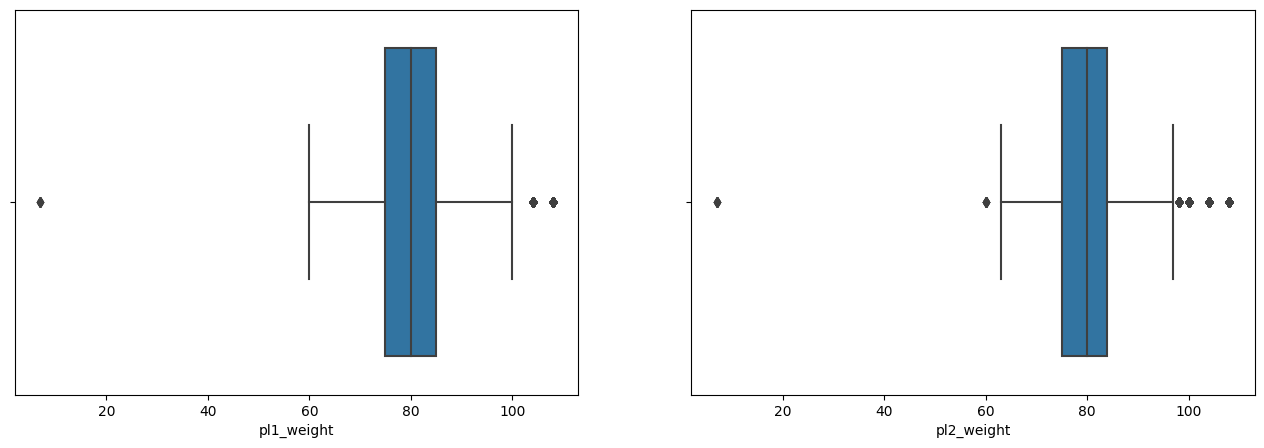

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))

sns.boxplot(data=ds, x='pl1_weight', ax=ax1)
sns.boxplot(data=ds, x='pl2_weight', ax=ax2)
plt.show()

The weight columns have some outlier values

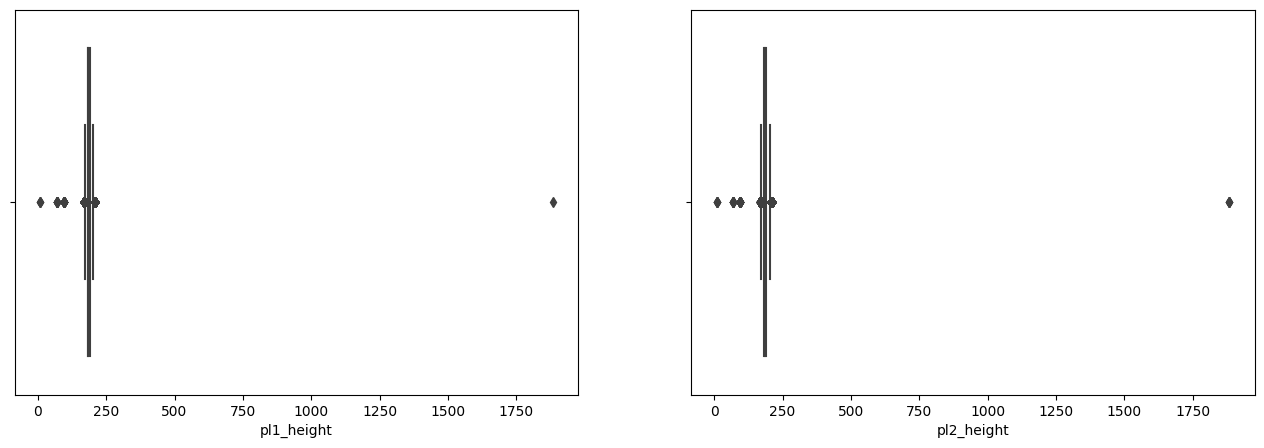

In [73]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))

sns.boxplot(data=ds, x='pl1_height', ax=ax1)
sns.boxplot(data=ds, x='pl2_height', ax=ax2)
plt.show()

The height columns have some outlier values

### Other Exploratory Analysis

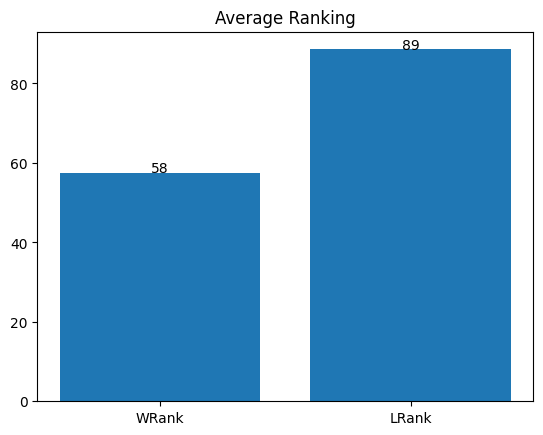

In [74]:
plt.bar(['WRank','LRank'], ds[['WRank','LRank']].mean().values)
for i, value in enumerate(ds[['WRank','LRank']].mean().values):
    plt.text(i, value + 0.1, f'{value:.0f}', ha='center')
plt.title('Average Ranking')
plt.savefig('Average ranking.jpg')
plt.show()

### Insight

- The Average Rank for Winners is 58th
- The Average Rank for losers is 89th.

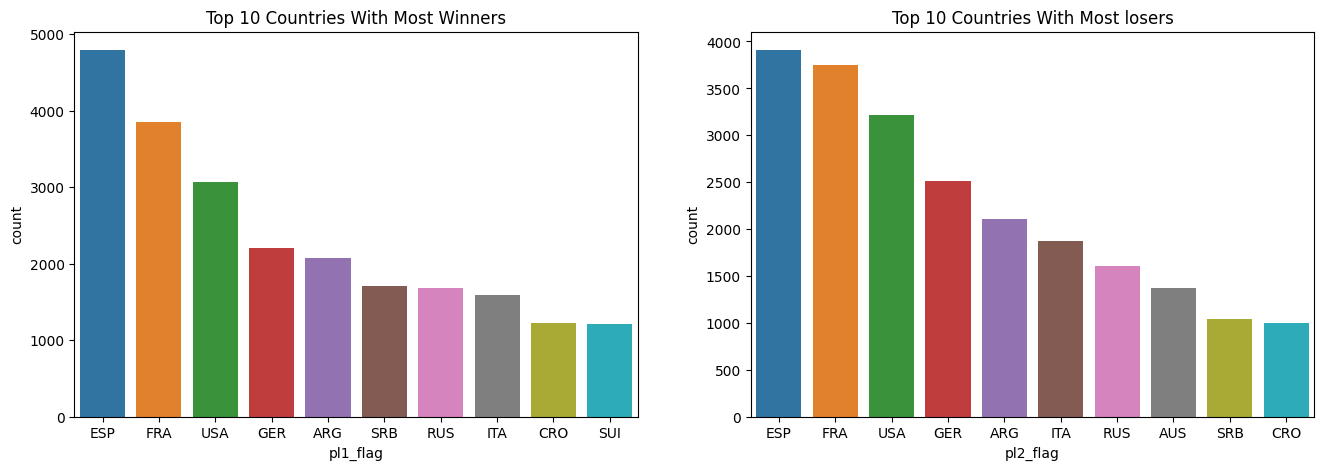

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))

country_with_most_winners = ds[['pl1_flag']].value_counts().reset_index()
country_with_most_losers = ds[['pl2_flag']].value_counts().reset_index()

sns.barplot(
    data=country_with_most_winners[:10],
    x='pl1_flag', y='count', ax=ax1
)

sns.barplot(
    data=country_with_most_losers[:10],
    x='pl2_flag', y='count', ax=ax2
)

ax1.set_title('Top 10 Countries With Most Winners')
ax2.set_title('Top 10 Countries With Most losers')

plt.savefig('Top 10 Countries for Winners and Losers.jpg')

plt.show()

The same 4 countries occupy the top 5 for both winners and losers. This suggests those countries are heavily represented at the tournaments.

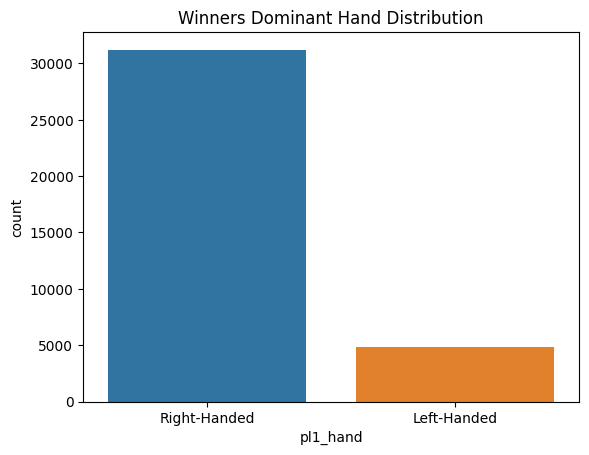

In [76]:
hand_with_most_winners = ds[['pl1_hand']].value_counts().reset_index()

sns.barplot(
    data=hand_with_most_winners[:10],
    x='pl1_hand', y='count'
)

plt.title('Winners Dominant Hand Distribution')
plt.show()

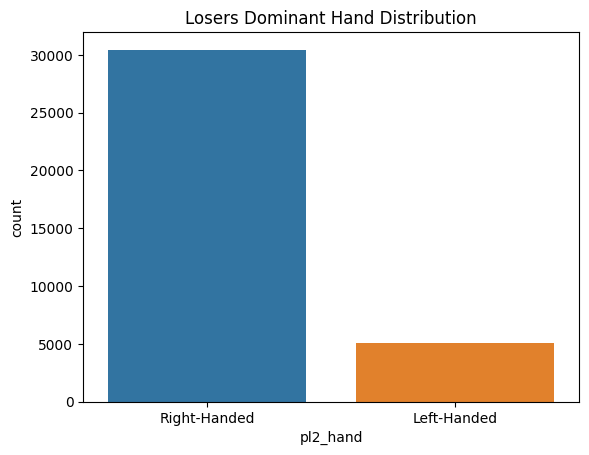

In [77]:
hand_with_most_losers = ds[['pl2_hand']].value_counts().reset_index()

sns.barplot(
    data=hand_with_most_losers[:10],
    x='pl2_hand', y='count'
)

plt.title('Losers Dominant Hand Distribution')
plt.show()

In [78]:
def remove_outliers(col, ds):
    '''
    Remove outliers from a column, using the inter-quartile range
    - calculate the upper limit and lower limit based on the IQR
    - filter out observations that fall out of range (< lower_limit or > upper_limit)
    '''
    if col == 'Status':
        return ds
   
    q1 = ds[col].quantile(0.25)
    q3 = ds[col].quantile(0.75)
    
    iqr = q3 - q1
    
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    
    return ds.drop(ds[(ds[col] < lower_limit) | (ds[col] > upper_limit)].index)

In [79]:
ds = remove_outliers('pl1_weight', ds)
ds = remove_outliers('pl2_weight', ds)
ds = remove_outliers('pl1_height', ds)
ds = remove_outliers('pl2_height', ds)

In [80]:
columns_with_less_missing_values = ds.columns[(ds.isnull().sum() / ds.shape[0])*100 < 10]

In [81]:
copy = ds[columns_with_less_missing_values]

In [82]:
copy.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,pl1_flag,pl1_year_pro,pl1_weight,pl1_height,pl1_hand,pl2_flag,pl2_year_pro,pl2_weight,pl2_height,pl2_hand
1,1,Adelaide,Adelaide International 1,2022-01-03,ATP250,Outdoor,Hard,1st Round,3,Monteiro T.,...,BRA,2011.0,78.0,183.0,Left-Handed,GER,2014.0,80.0,188.0,Right-Handed
2,1,Adelaide,Adelaide International 1,2022-01-03,ATP250,Outdoor,Hard,1st Round,3,Djere L.,...,SRB,2013.0,80.0,185.0,Right-Handed,ESP,2011.0,76.0,180.0,Right-Handed
3,1,Adelaide,Adelaide International 1,2022-01-03,ATP250,Outdoor,Hard,1st Round,3,Johnson S.,...,USA,2012.0,86.0,188.0,Right-Handed,AUS,2018.0,85.0,188.0,Right-Handed
4,1,Adelaide,Adelaide International 1,2022-01-04,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,...,FRA,2016.0,71.0,175.0,Left-Handed,DEN,2020.0,77.0,188.0,Right-Handed
5,1,Adelaide,Adelaide International 1,2022-01-04,ATP250,Outdoor,Hard,1st Round,3,Daniel T.,...,JPN,2010.0,76.0,191.0,Right-Handed,ITA,2019.0,78.0,185.0,Right-Handed


In [83]:
copy.shape

(33358, 32)

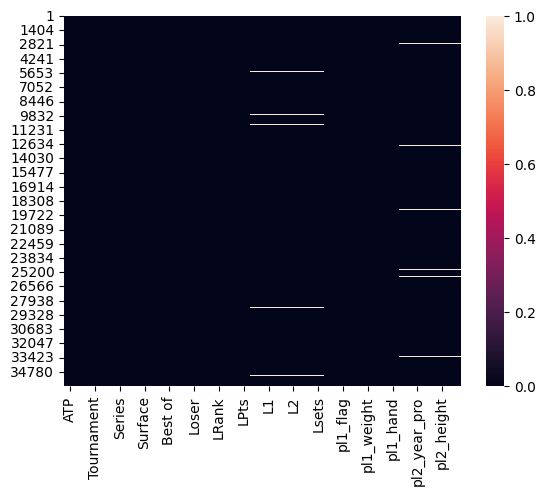

In [84]:
sns.heatmap(copy.isnull())
plt.show()

In [85]:
copy['Comment'].unique()

array(['Completed', 'Retired', 'Walkover', 'Awarded', 'Rrtired',
       'Disqualified', 'Sched'], dtype=object)

In [86]:
copy.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'Wsets', 'Lsets', 'Comment', 'pl1_flag',
       'pl1_year_pro', 'pl1_weight', 'pl1_height', 'pl1_hand', 'pl2_flag',
       'pl2_year_pro', 'pl2_weight', 'pl2_height', 'pl2_hand'],
      dtype='object')

In [87]:
copy = copy.drop(['WPts', 'LPts', 'W1',
       'L1', 'W2', 'L2', 'Wsets', 'Lsets', 'Comment'], axis=1)

In [88]:
copy.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank            13
LRank            76
pl1_flag         93
pl1_year_pro     93
pl1_weight       93
pl1_height       93
pl1_hand         93
pl2_flag        632
pl2_year_pro    632
pl2_weight      632
pl2_height      632
pl2_hand        632
dtype: int64

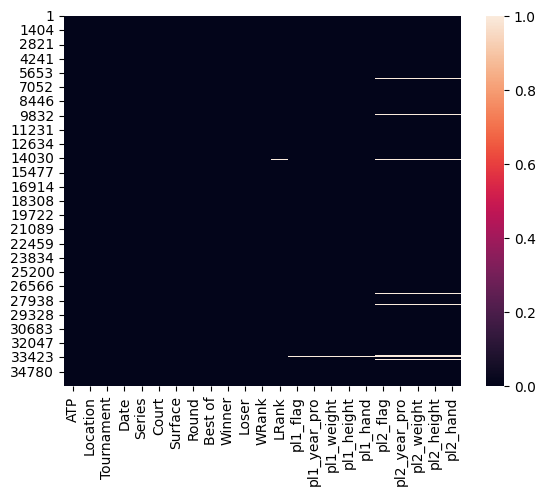

In [89]:
sns.heatmap(copy.isnull())
plt.show()

In [90]:
copy[copy['pl2_hand'].isna()]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,pl1_flag,pl1_year_pro,pl1_weight,pl1_height,pl1_hand,pl2_flag,pl2_year_pro,pl2_weight,pl2_height,pl2_hand
37,2,Melbourne,Melbourne Summer Set,2022-01-05,ATP250,Outdoor,Hard,1st Round,3,Cressy M.,...,USA,2019.0,91.0,198.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
92,4,Sydney,Sydney Tennis Classic,2022-01-11,ATP250,Outdoor,Hard,1st Round,3,Murray A.,...,GBR,2005.0,84.0,191.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
136,5,Melbourne,Australian Open,2022-01-17,Grand Slam,Outdoor,Hard,1st Round,5,Otte O.,...,GER,2011.0,79.0,183.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
144,5,Melbourne,Australian Open,2022-01-18,Grand Slam,Outdoor,Hard,1st Round,5,Gombos N.,...,SVK,2009.0,85.0,196.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
150,5,Melbourne,Australian Open,2022-01-18,Grand Slam,Outdoor,Hard,1st Round,5,Dimitrov G.,...,BUL,2008.0,80.0,191.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35836,57,Moscow,Kremlin Cup,2008-10-07,International,Indoor,Carpet,1st Round,3,Safin M.,...,RUS,1997.0,88.0,193.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
35869,58,Stockholm,Stockholm Open,2008-10-08,International,Indoor,Hard,1st Round,3,Clement A.,...,FRA,1996.0,74.0,173.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
35895,59,Vienna,BA-CA Tennis Trophy,2008-10-07,International Gold,Indoor,Hard,1st Round,3,Stepanek R.,...,CZE,1996.0,76.0,185.0,Right-Handed,NaN,NaN,NaN,NaN,NaN
35987,61,Basel,Davidoff Swiss Indoors,2008-10-23,International,Indoor,Carpet,2nd Round,3,Del Potro J.M.,...,ARG,2005.0,97.0,198.0,Right-Handed,NaN,NaN,NaN,NaN,NaN


In [91]:
copy[copy['Winner'] == 'Durasovic V.']

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,pl1_flag,pl1_year_pro,pl1_weight,pl1_height,pl1_hand,pl2_flag,pl2_year_pro,pl2_weight,pl2_height,pl2_hand


In [92]:
copy.nunique()

ATP               67
Location         106
Tournament       174
Date            3868
Series             8
Court              2
Surface            4
Round              8
Best of            2
Winner           676
Loser           1053
WRank            518
LRank            798
pl1_flag          67
pl1_year_pro      32
pl1_weight        37
pl1_height        17
pl1_hand           2
pl2_flag          70
pl2_year_pro      34
pl2_weight        34
pl2_height        17
pl2_hand           2
dtype: int64

In [93]:
copy.loc[:, 'Year'] = copy['Date'].dt.year
copy.loc[:, 'Month'] = copy['Date'].dt.month

In [94]:
copy = copy.drop('Date',axis=1)

In [95]:
copy.columns

Index(['ATP', 'Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'pl1_flag',
       'pl1_year_pro', 'pl1_weight', 'pl1_height', 'pl1_hand', 'pl2_flag',
       'pl2_year_pro', 'pl2_weight', 'pl2_height', 'pl2_hand', 'Year',
       'Month'],
      dtype='object')

In [96]:
cols_to_encode = ['Location', 'Tournament', 'Series', 'Surface', 'Round', 'Winner', 'Loser', 'pl1_flag',
       'pl2_flag']

In [97]:
for cols in cols_to_encode:
    encoder = LabelEncoder()
    copy.loc[:, cols] = encoder.fit_transform(copy[cols])

In [98]:
copy.loc[:,'Court'] = copy['Court'].map({'Outdoor': 1, 'Indoor': 0})

In [99]:
copy.loc[:,'pl1_hand'] = copy['pl1_hand'].map({'Right-Handed': 1, 'Left-Handed': 0})
copy.loc[:,'pl2_hand'] = copy['pl2_hand'].map({'Right-Handed': 1, 'Left-Handed': 0})

In [100]:
copy.head()

,ATP,Location,Tournament,Series,Court,Surface,Round,Best of,Winner,Loser,...,pl1_weight,pl1_height,pl1_hand,pl2_flag,pl2_year_pro,pl2_weight,pl2_height,pl2_hand,Year,Month
1,1,2,10,0,1,3,0,3,421,17,...,78.0,183.0,0.0,28,2014.0,80.0,188.0,1.0,2022,1
2,1,2,10,0,1,3,0,3,148,142,...,80.0,185.0,1.0,22,2011.0,76.0,180.0,1.0,2022,1
3,1,2,10,0,1,3,0,3,283,992,...,86.0,188.0,1.0,2,2018.0,85.0,188.0,1.0,2022,1
4,1,2,10,0,1,3,0,3,424,801,...,71.0,175.0,0.0,18,2020.0,77.0,188.0,1.0,2022,1
5,1,2,10,0,1,3,0,3,118,664,...,76.0,191.0,1.0,34,2019.0,78.0,185.0,1.0,2022,1


In [101]:
imputer = KNNImputer(n_neighbors=5)

copy.loc[:, copy.columns] = imputer.fit_transform(copy)

In [102]:
copy.isna().sum()

ATP             0
Location        0
Tournament      0
Series          0
Court           0
Surface         0
Round           0
Best of         0
Winner          0
Loser           0
WRank           0
LRank           0
pl1_flag        0
pl1_year_pro    0
pl1_weight      0
pl1_height      0
pl1_hand        0
pl2_flag        0
pl2_year_pro    0
pl2_weight      0
pl2_height      0
pl2_hand        0
Year            0
Month           0
dtype: int64

In [103]:
def randomize_players(df):
    swap_mask = np.random.rand(len(df)) > 0.5

    df_randomized = df.copy()
    
    df_randomized.loc[:, 'Match_Winner'] = df['Winner']

    player_cols = ['year_pro', 'weight', 'height', 'hand', 'flag']
    for col in player_cols:
        df_randomized.loc[swap_mask, [f'pl1_{col}', f'pl2_{col}']] = df.loc[swap_mask, [f'pl2_{col}', f'pl1_{col}']].values

    df_randomized.loc[swap_mask, ['WRank', 'LRank']] = df.loc[swap_mask, ['LRank', 'WRank']].values

    df_randomized.loc[swap_mask, ['Winner', 'Loser']] = df.loc[swap_mask, ['Loser', 'Winner']].values
    
#     df_randomized.loc[swap_mask, ['WPts', 'LPts']] = df.loc[swap_mask, ['LPts', 'WPts']].values

    return df_randomized

df_randomized = randomize_players(copy)

df_randomized = df_randomized.rename(columns={
    'Winner': 'Player_1',
    'Loser': 'Player_2',
    'WRank': 'P1_Rank',
    'LRank': 'P2_Rank',
#     'WPts': 'P1_Points',
#     'LPts': 'P2_Points',
    'pl1_year_pro': 'P1_year_pro',
    'pl1_weight': 'P1_weight',
    'pl1_height': 'P1_height',
    'pl1_hand': 'P1_hand',
    'pl2_year_pro': 'P2_year_pro',
    'pl2_weight': 'P2_weight',
    'pl2_height': 'P2_height',
    'pl2_hand': 'P2_hand',
    'pl1_flag': 'P1_flag',
    'pl2_flag': 'P2_flag'
})

In [104]:
df_randomized.head()

,ATP,Location,Tournament,Series,Court,Surface,Round,Best of,Player_1,Player_2,...,P1_height,P1_hand,P2_flag,P2_year_pro,P2_weight,P2_height,P2_hand,Year,Month,Match_Winner
1,1,2.0,10.0,0.0,1.0,3.0,0.0,3,421.0,17.0,...,183.0,0.0,28.0,2014.0,80.0,188.0,1.0,2022,1,421.0
2,1,2.0,10.0,0.0,1.0,3.0,0.0,3,148.0,142.0,...,185.0,1.0,22.0,2011.0,76.0,180.0,1.0,2022,1,148.0
3,1,2.0,10.0,0.0,1.0,3.0,0.0,3,283.0,992.0,...,188.0,1.0,2.0,2018.0,85.0,188.0,1.0,2022,1,283.0
4,1,2.0,10.0,0.0,1.0,3.0,0.0,3,801.0,424.0,...,188.0,1.0,24.0,2016.0,71.0,175.0,0.0,2022,1,424.0
5,1,2.0,10.0,0.0,1.0,3.0,0.0,3,118.0,664.0,...,191.0,1.0,34.0,2019.0,78.0,185.0,1.0,2022,1,118.0


In [105]:
df_randomized.loc[:, 'Winner'] = (df_randomized['Player_1'] == df_randomized['Match_Winner']).astype('int')

In [106]:
df_randomized = df_randomized.drop(['Match_Winner'], axis=1)

In [107]:
df_randomized.head()

,ATP,Location,Tournament,Series,Court,Surface,Round,Best of,Player_1,Player_2,...,P1_height,P1_hand,P2_flag,P2_year_pro,P2_weight,P2_height,P2_hand,Year,Month,Winner
1,1,2.0,10.0,0.0,1.0,3.0,0.0,3,421.0,17.0,...,183.0,0.0,28.0,2014.0,80.0,188.0,1.0,2022,1,1
2,1,2.0,10.0,0.0,1.0,3.0,0.0,3,148.0,142.0,...,185.0,1.0,22.0,2011.0,76.0,180.0,1.0,2022,1,1
3,1,2.0,10.0,0.0,1.0,3.0,0.0,3,283.0,992.0,...,188.0,1.0,2.0,2018.0,85.0,188.0,1.0,2022,1,1
4,1,2.0,10.0,0.0,1.0,3.0,0.0,3,801.0,424.0,...,188.0,1.0,24.0,2016.0,71.0,175.0,0.0,2022,1,0
5,1,2.0,10.0,0.0,1.0,3.0,0.0,3,118.0,664.0,...,191.0,1.0,34.0,2019.0,78.0,185.0,1.0,2022,1,1


In [108]:
df_randomized['Winner'].value_counts()

Winner
1    16739
0    16619
Name: count, dtype: int64

In [109]:
X = df_randomized.drop('Winner', axis=1).values
y = df_randomized['Winner'].values

In [110]:
basline_accuracy = accuracy_score(y, np.ones(len(y)))

print(f"Baseline Accuracy: {basline_accuracy}")

Baseline Accuracy: 0.5017986689849512


In [111]:
cv = TimeSeriesSplit(n_splits=5)

In [112]:
scaler = StandardScaler()

In [113]:
X_scaled = scaler.fit_transform(X)

In [114]:
rfc = RandomForestClassifier(random_state=11)

In [115]:
rfc.fit(X, y)

RandomForestClassifier(random_state=11)

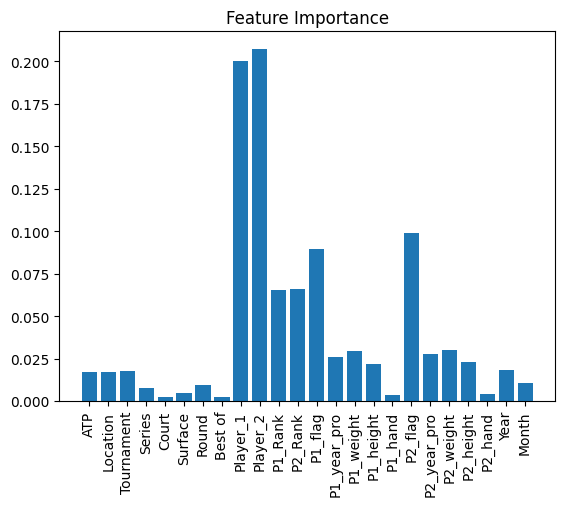

In [116]:
plt.bar(df_randomized.drop('Winner', axis=1).columns, rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.savefig('Feature Importance.jpg')
plt.show()

### Key Insights from Feature Importance Data

- **Player Identities**: `Player_1` (0.2123) and `Player_2` (0.1998) are the most important features.
- **Player Rankings**: `P1_Rank` (0.0647) and `P2_Rank` (0.0661) significantly impact outcomes.
- **Player Nationality**: `P1_flag` (0.0896) and `P2_flag` (0.0964) have notable influence.
- **Physical Attributes**: `P1_weight` (0.0288) and `P2_weight` (0.0280) are moderately important, with height (`P1_height` and `P2_height`) also contributing.
- **Experience**: `P1_year_pro` (0.0267) and `P2_year_pro` (0.0264) are moderately significant.
- **Match Details**: Features like `ATP` (0.0181), `Location` (0.0178), and `Tournament` (0.0173) have some impact.
- **Court and Surface**: Minimal influence with `Court` (0.0023) and `Surface` (0.0050).
- **Temporal Factors**: `Year` (0.0185) and `Month` (0.0108) show some significance.

This summary highlights the most influential features for predicting match outcomes, emphasizing the importance of player-specific attributes.

In [117]:
feature_importance = pd.DataFrame({'Weight': rfc.feature_importances_, 'Column': df_randomized.drop('Winner', axis=1).columns}).sort_values('Weight')

In [118]:
feature_importance[feature_importance['Weight'] >= 0.01]['Column'].values

array(['Month', 'Location', 'ATP', 'Tournament', 'Year', 'P1_height',
       'P2_height', 'P1_year_pro', 'P2_year_pro', 'P1_weight',
       'P2_weight', 'P1_Rank', 'P2_Rank', 'P1_flag', 'P2_flag',
       'Player_1', 'Player_2'], dtype=object)

In [119]:
useful_columns = feature_importance[feature_importance['Weight'] >= 0.01]['Column'].values

X = df_randomized[useful_columns].values
y = df_randomized['Winner'].values

X_scaled = scaler.fit_transform(X)

In [120]:
rfc_val_scores = cross_val_score(rfc, X_scaled, y, cv=cv, n_jobs=-1, scoring='accuracy')

In [121]:
print(f"Mean Accuracy: {rfc_val_scores.mean()}")

Mean Accuracy: 0.9522216225939918


In [122]:
lgbm = LGBMClassifier(verbose=-1, random_state=11)

lgbm_val_scores = cross_val_score(lgbm, X_scaled, y, cv=cv, n_jobs=-1, scoring='accuracy')

print(lgbm_val_scores)

print(f"Mean Accuracy: {lgbm_val_scores.mean()}")

[0.96941896 0.98488937 0.98920669 0.98560892 0.96833963]
Mean Accuracy: 0.9794927145169995


#### Before adding Flag and Month Feature
- [0.95847176 0.98488372 0.98554817 0.98521595 0.97657807]
- Mean Accuracy: 0.978139534883721

In [123]:
lgbm_param_grid = {
    'num_leaves': [31, 61],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0]
}

lgbm_grid = GridSearchCV(lgbm, scoring='accuracy', n_jobs=-1, cv=cv, param_grid=lgbm_param_grid)
lgbm_grid.fit(X_scaled, y)

print(lgbm_grid.best_score_, lgbm_grid.best_params_)

0.9876956287101996 {'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 400, 'num_leaves': 31, 'subsample': 0.8}


In [124]:
cat = CatBoostClassifier(verbose=0, random_state=11)

cat_val_scores = cross_val_score(cat, X_scaled, y, cv=cv, n_jobs=-1, scoring='accuracy')

print(cat_val_scores)

print(f"Mean Accuracy: {cat_val_scores.mean()}")

[0.96762008 0.98812736 0.99262457 0.99136535 0.97769383]
Mean Accuracy: 0.9834862385321103


#### Before adding Flag and Month Feature
- [0.94651163 0.97574751 0.97275748 0.97142857 0.96229236]
- Mean Accuracy: 0.9657475083056479

In [125]:
cat_param_grid = {
    'depth': [6, 8, 10], 
    'iterations': [400, 1000],
    'l2_leaf_reg': [1, 3, 5],
    'subsample': [0.8],
    'colsample_bylevel': [0.8]
}

cat_grid = GridSearchCV(cat, scoring='accuracy', n_jobs=-1, cv=cv, param_grid=cat_param_grid)
cat_grid.fit(X_scaled, y)

print(cat_grid.best_score_, cat_grid.best_params_)

0.9885590933621154 {'colsample_bylevel': 0.8, 'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 1, 'subsample': 0.8}


In [126]:
xgb = XGBClassifier(random_state=11)

xgb_val_scores = cross_val_score(xgb, X_scaled, y, cv=cv, n_jobs=-1, scoring='accuracy')

print(xgb_val_scores)

print(f"Mean Accuracy: {xgb_val_scores.mean()}")

[0.96923907 0.98776758 0.99208491 0.9875877  0.97247706]
Mean Accuracy: 0.9818312646159381


In [143]:
xgb_param_grid = {
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting each tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used for fitting each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2],  # L2 regularization term on weights,
    'n_estimators': [500, 1000]
}

xgb_grid = RandomizedSearchCV(xgb, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, param_distributions=xgb_param_grid)
xgb_grid.fit(X_scaled, y)

print(xgb_grid.best_score_, xgb_grid.best_params_)

0.9825867961863646 {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [132]:
from sklearn.ensemble import StackingClassifier

In [144]:
lgbm_est = LGBMClassifier(verbose=-1, random_state=11, **lgbm_grid.best_params_)
cat_est = CatBoostClassifier(verbose=0, random_state=11, **cat_grid.best_params_)
xgb_est = XGBClassifier(random_state=11, **xgb_grid.best_params_)

estimators = [
    ('lgbm', lgbm_est),
    ('cat', cat_est),
    ('xgb', xgb_est)
]

In [145]:
stack = StackingClassifier(estimators, cv=2)

stack_val_scores = cross_val_score(stack, X_scaled, y, cv=cv, n_jobs=-1, scoring='accuracy')

print(stack_val_scores)

print(f"Mean Accuracy: {stack_val_scores.mean()}")

[0.98003238 0.99388379 0.99550279 0.99478323 0.98201115]
Mean Accuracy: 0.9892426695448823


## Model Selection

In [146]:
model_results = pd.DataFrame({
    'model': ['STK', 'CAT', 'LGBM', 'XGB', 'RFC'],
    'best_cv_score': [stack_val_scores.mean()*100, cat_grid.best_score_*100, lgbm_grid.best_score_*100, xgb_grid.best_score_*100, rfc_val_scores.mean()*100]
})

In [147]:
model_results

,model,best_cv_score
0,STK,98.924267
1,CAT,98.855909
2,LGBM,98.769563
3,XGB,98.258680
4,RFC,95.222162


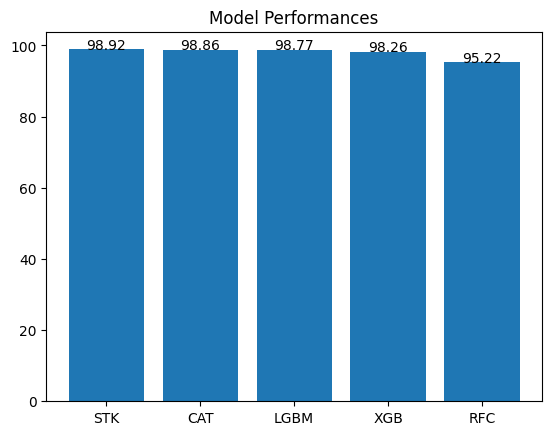

In [149]:
plt.bar(model_results['model'], model_results['best_cv_score'])
for i, value in enumerate(model_results['best_cv_score']):
    plt.text(i, value + 0.005, f'{value:.2f}', ha='center')
plt.title('Model Performances')
plt.savefig('Model Performances.jpg')
plt.show()

### Decision
Given the highest performance, the Stacking Classifier model has been chosen for further development and deployment.